### base

In [1]:
import sentencepiece as spm
import numpy as np 
import pandas as pd 

sp = spm.SentencePieceProcessor()

model_name = 'm_30.model'
vocab_name = 'm_30.vocab'
sp.load('./sp_models/'+ model_name)

True

In [2]:
train_data = pd.read_pickle("../data/train/train_data.pkl")
test_data = pd.read_pickle("../data/test/test_data.pkl")

In [3]:
def convert_to_id(data, sp_model, text_col, label_col):
    X_ids=[]
    for i in data[text_col]:
        X_ids.append(sp_model.encode_as_ids(i))
    df = pd.DataFrame(X_ids).join(data[label_col])
    return df

In [4]:
df = convert_to_id(train_data, sp, 'Text', 'Label')
test_df = convert_to_id(test_data, sp, 'Text', 'Label')

In [5]:
df

,0,1,2,3,4,5,6,7,8,9,...,123,124,125,126,127,128,129,130,131,Label
0,20.0,4841.0,19.0,3273.0,148.0,1217.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2027.0,16494.0,280.0,4267.0,224.0,257.0,16925.0,2115.0,2827.0,17317.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,16.0,435.0,0.0,645.0,4180.0,150.0,19049.0,1311.0,367.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,25695.0,452.0,10327.0,751.0,6430.0,325.0,4855.0,13912.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1560.0,2559.0,1214.0,231.0,10.0,5066.0,373.0,5647.0,3435.0,27921.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144309,1070.0,4280.0,173.0,2789.0,5573.0,2789.0,94.0,334.0,89.0,5573.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
144310,2764.0,704.0,14.0,407.0,7.0,792.0,3624.0,306.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
144311,238.0,120.0,25.0,3500.0,12.0,48.0,62.0,27229.0,11.0,17111.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
144312,4434.0,1928.0,22275.0,298.0,2270.0,49.0,3204.0,595.0,199.0,876.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [6]:
seed = 100
train_df = df.copy()
df0=df.loc[(df['Label']==0)].sample(n = 20000, random_state = seed) 
train_df = train_df.drop(df0.index)
print(len(train_df))
df1=df.loc[(df['Label']==1)].sample(n = 20000, random_state = seed) 
train_df = train_df.drop(df1.index)
print(len(train_df))

train_df.reset_index(drop=True, inplace=True)
eval_df = pd.DataFrame()
eval_df = df0.append(df1)
eval_df.reset_index(drop=True, inplace=True)

124314
104314


In [7]:
def countLabel(data):
    count0 = 0
    count1 = 0
    for label in data:
        if label == 0: 
            count0+=1
        elif label == 1: 
            count1+=1
    total = len(data)
    print("총 데이터 개수:", total)
    print("class 0 개수: %d, 비율: %.2f"%(count0, count0/total))
    print("class 1 개수: %d, 비율: %.2f"%(count1, count1/total))

In [8]:
countLabel(train_df['Label'])
countLabel(eval_df['Label'])
countLabel(test_df['Label'])

총 데이터 개수: 104314
class 0 개수: 52434, 비율: 0.50
class 1 개수: 51880, 비율: 0.50
총 데이터 개수: 40000
class 0 개수: 20000, 비율: 0.50
class 1 개수: 20000, 비율: 0.50
총 데이터 개수: 50000
class 0 개수: 24827, 비율: 0.50
class 1 개수: 25173, 비율: 0.50


In [9]:
def pre_truncating(data, max_len):
    for num in range(len(data) - max_len):
        data.pop(0)
    return data

def pre_padding(data, max_len, padding_value):
    for num in range(max_len - len(data)):
        data.insert(0, padding_value)
    return data
    
# def post_padding():
# def pre_truncating():
    
def pad(df, max_len, padding, padding_value):
    X = df.values.tolist()
    X_ = []
    for index, ids in enumerate(X):
        X_.append([int(i) for i in ids if str(i) != 'nan'])
    
    #padding 
    if padding == 'pre':
        pad=[]
        for ids in X_:
            if len(ids) < max_len:
                p = pre_padding(ids, max_len, padding_value)
            elif len(ids) > max_len:
                p = pre_truncating(ids, max_len)
            else : 
                p = ids
            pad.append(p)
      
#     if padding == 'post':
        
    return np.array(pad) 

In [10]:
max_len = 40
train_pad = pad(train_df.iloc[:,:-1], max_len, "pre", 0)
eval_pad = pad(eval_df.iloc[:,:-1], max_len, "pre", 0)
test_pad = pad(test_df.iloc[:,:-1], max_len, "pre", 0)

In [11]:
print(len(train_df),len(train_pad))
print(len(eval_df),len(eval_pad))
print(len(test_df),len(test_pad))

104314 104314
40000 40000
50000 50000


# Simple LSTM

In [12]:
from tensorflow.python.keras.datasets import reuters
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.models import load_model

In [13]:
import sentencepiece as spm
sp = spm.SentencePieceProcessor()

model_name = 'm_30.model'
vocab_name = 'm_30.vocab'
sp.load('./sp_models/'+ model_name)


True

In [25]:
#version: class-weight 적용 안함 
from tensorflow import keras
import re
from tqdm import tqdm
import tensorflow as tf
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.models import load_model
from keras.utils.np_utils import to_categorical
#from sklearn.model_selection import StratifiedKFold
#kfold=StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
#cvscores=[]
num_words=30000
hidden = 100

es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc = ModelCheckpoint('lstm_model(base)_v2.h5', monitor='val_acc',mode='max', 
                     verbose=0, save_best_only=True)

with tf.device('/CPU:0'):
        
    model = Sequential()
    #Embedding(number of samples(단어 사전 크기), hidden layer size)
    model.add(Embedding(num_words, hidden))
    model.add(LSTM(hidden, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(hidden, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(hidden))
    model.add(Dense(2, activation='softmax'))
#     lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=3e-3, 
#                                                               decay_steps=10000, decay_rate=0.85)
#     opt = keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['acc'])
    history = model.fit(train_pad, to_categorical(train_df['Label'], num_classes=2), batch_size=100, epochs=200, 
                        verbose=1, callbacks=[es, mc], 
                        validation_data=(eval_pad,to_categorical(eval_df['Label'], num_classes=2)))
    predict_num = model.predict_classes(eval_pad)
    file_name='./result/check_cases/predict_wrong(base)_v2.tsv'
    caseBoard = pd.DataFrame()
    for i, real in enumerate(eval_df['Label']):
        if(real != predict_num[i]):
            myList = [round(x) for x in train_pad[i].tolist()]
            line = re.sub('⁇','',sp.decode_ids(myList))
            newDict = {'real': str(real), 'predict':str(predict_num[i]), 'text':line}
            caseBoard = caseBoard.append(newDict, ignore_index = True)
    caseBoard.to_csv( file_name, index=False, sep='\t')

Epoch 1/200
1044/1044 [==============================] - 87s 83ms/step - loss: 0.4045 - acc: 0.8112 - val_loss: 0.3477 - val_acc: 0.8437
Epoch 2/200
1044/1044 [==============================] - 128s 123ms/step - loss: 0.2819 - acc: 0.8818 - val_loss: 0.3553 - val_acc: 0.8502
Epoch 3/200
1044/1044 [==============================] - 128s 123ms/step - loss: 0.2151 - acc: 0.9119 - val_loss: 0.3769 - val_acc: 0.8462
Epoch 4/200
1044/1044 [==============================] - 132s 127ms/step - loss: 0.1589 - acc: 0.9370 - val_loss: 0.4504 - val_acc: 0.8389
Epoch 5/200
 429/1044 [===========>..................] - ETA: 1:09 - loss: 0.1018 - acc: 0.9620

KeyboardInterrupt: 

In [19]:
#load model and evaluate 
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

with tf.device('/CPU:0'):
    re_model = load_model('lstm_model(base).h5')
#     re_model.fit(train_pad.iloc[:,:-1], to_categorical(train_pad['label'], num_classes=3))
    y_pred1 = re_model.predict_classes(test_pad)

target_names=['0', '1']
print("Accuracy:", metrics.accuracy_score(test_df['Label'], y_pred1))
print(confusion_matrix(test_df['Label'], y_pred1))
print(classification_report(test_df['Label'], y_pred1, target_names=target_names))

Accuracy: 0.84874
[[21100  3727]
 [ 3836 21337]]
              precision    recall  f1-score   support

           0       0.85      0.85      0.85     24827
           1       0.85      0.85      0.85     25173

    accuracy                           0.85     50000
   macro avg       0.85      0.85      0.85     50000
weighted avg       0.85      0.85      0.85     50000



/home/yoonjin/anaconda3/envs/medinfo/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "box_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  


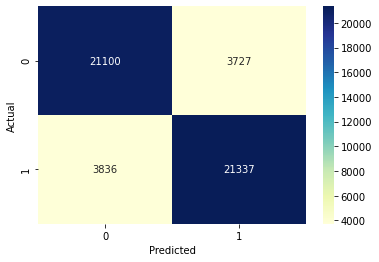

In [24]:
import seaborn as sn
data_= {'y_Actual':test_df['Label'], 'y_Predicted': y_pred1}
df_cm = pd.DataFrame(data_, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df_cm['y_Actual'], df_cm['y_Predicted'],
                               rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.savefig('./result/check_cases/base.png', box_inches='tight')
plt.show()